## TODO

0. Use raw score (output_margin=True)
1. Run on all old labeled data
2. Run on new data
3. Map data on to Fladermaus
4. Collect the full trajectory of scores

## [Jump to analysis](#Analysis)

In [1]:
# %load xgsea.py
import os
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import argparse
import random
import pickle

In [2]:
''' notes
max depth 8, num rounds 20 -> .85 r^2
             num rounds 30 -> .87

        + max_delta_step 2 -> .88

fixed data set
                           -> .89
added depthdiff column
                           -> .93
removed id column
                           -> .89
gamma=.7 parameter added
                           -> .89 (.002 increase)

jamstec
'eta': 1,
 'max_delta_step': 1,
 'max_depth': 11,
 'nthread': 4,
 'objective': 'binary:logistic',
 'silent': 1}              -> .87


'''

def read(f):
    # names = ['long','lat','depth','sigma_h','sigma_d','source_id','pred_depth','dens20', 'dens60','gravity','age','rate','sed thick', 'roughness', 'dens10']
    
    print('reading in data')
    #data = pd.read_csv(f, delimiter='\s+', names=names)
    data = pd.read_hdf(f)
    
    return make_xgstuff(clean(data))

def clean(data):
    y = 'sigma_d'
    # replace na with mean
    print('cleaning data')
    data.fillna(data.mean(), inplace=True)
    
    # change sigma_d to boolean, new method using list comprehension
    data[y] = [x == 9999 for x in data[y]]

    # create depthdiff column
    data['depthdiff'] = data['depth'] - data['pred_depth']

    # cleaner way to drop columns
    return data.drop(['depth', 'source_id'], axis=1)

def make_xgstuff(data):
    y = 'sigma_d'
    # split
    train, test = train_test_split(data, test_size=.3)

    # defines independent column names for test set
    x = [x != y for x in list(data.columns)]
    
    # splits dataframe into x and y vectors
    xtest = test.ix[:,x]
    ytest = test[y]

    xtrain = train.ix[:,x]
    ytrain = train[y]

    # convert to xgb data structures
    xgtrain = xgb.DMatrix(xtrain.values, ytrain.values, 
                          feature_names=list(xtrain.columns))
    xgtest = xgb.DMatrix(xtest.values, feature_names=list(xtrain.columns))
    
    return xgtrain, xgtest, ytest

In [3]:
# if __name__ == '__main__':
# argument parser

"""
parser = argparse.ArgumentParser(description = 
    'generates xgb model from seafloor dataset')

parser.add_argument('dataset',
                    help = 'hdf dataset to model')

parser.add_argument('name', 
                    help = 'name of dataset')

arg = parser.parse_args()
"""

arg = {}
arg["dataset"] = "../nga.hdf5"
arg["name"] = "nga"

# housekeeping
random.seed(1105)

xgtrain, xgtest, ytest = read(arg["dataset"])

# parameters
param = {
    'jam': { # works well with geodas, sio also
        'max_depth':11, 
        'eta':1, 
        'silent':1, 
        'objective':'binary:logistic',
        'nthread':6,
        'max_delta_step':1
    },
    'nga': {
        'max_depth':10,
        'max_delta_step':2,
        'gamma':.7,
        'eta':1, 
        'objective':'binary:logistic',
        'nthread':4,
        'silent':1
    },
    'sio': {
        'max_depth':20,
        'eta':1,
        'silent':1,
        'objective':'binary:logistic',
        'nthread':6,
        'max_delta_step':1
    },
}

param['ngdc'] = {**param['jam'], 'max_depth':8}

num_round = 30

reading in data
cleaning data


/Users/arapat/dev/virtualenv/py3/lib/python3.6/site-packages/ipykernel_launcher.py:60: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/arapat/dev/virtualenv/py3/lib/python3.6/site-packages/ipykernel_launcher.py:63: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [4]:
# train
print('training')

if arg["name"] not in param:
    print('no params found for dataset, using jamstec as default')
    name = 'jam'

else:
    name = arg["name"]

bst = xgb.train(param[name], xgtrain, num_round)

training


In [5]:
bst.save_model("bst.model")

In [20]:
# test
#print('calculating r2')
all_preds = []
for k in range(1, num_round + 1):
    all_preds.append(bst.predict(xgtest, ntree_limit=k))
preds = bst.predict(xgtest)

# print error
get_err = lambda preds: sum(1 for pred, actual in zip(preds, ytest) if (pred>.5)!=actual) / len(preds)
errs = list(map(get_err, all_preds))
err = get_err(preds)
print('error: {:.2%}'.format(err))

# roc
all_auc = [metrics.roc_auc_score(ytest, pred) for pred in all_preds]
print(metrics.roc_auc_score(ytest, preds))

error: 1.87%
0.997524299392


In [12]:
import numpy as np


# test
#print('calculating r2')
path = []
for k in range(1, num_round + 1):
    path.append(bst.predict(xgtest, output_margin=True, ntree_limit=k))
path = np.array(path).T

In [22]:
# pickle.dump((ytest, all_preds, path), open("prediction.pkl", "wb"))

In [7]:
import pickle

(ytest, all_preds, path) = pickle.load(open("prediction.pkl", "rb"))
preds = all_preds[-1]

# Analysis

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [9]:
ytest_array = np.array(ytest)
no_ytest_array = np.logical_not(ytest_array)
npos, nneg = preds[ytest_array].shape[0], preds[no_ytest_array].shape[0]
base_err = max(npos, nneg) / (npos + nneg)
print(
    "Number of positive examples: {}\n"
    "Number of negative examples: {}\n"
    "Base line error rate: {}".format(
        npos, nneg, base_err
    )
)

Number of positive examples: 319918
Number of negative examples: 1324341
Base line error rate: 0.8054333289341886


### Performance

Text(0.5,0,'Iteration')

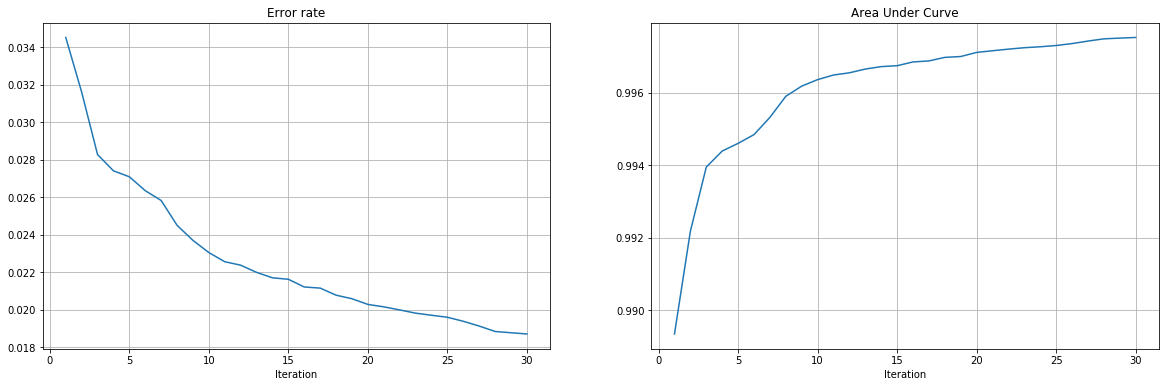

In [56]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(range(1, len(errs) + 1), errs)
plt.grid()
plt.title("Error rate")
plt.xlabel("Iteration")
plt.subplot(122)
plt.plot(range(1, len(errs) + 1), all_auc)
plt.grid()
plt.title("Area Under Curve")
plt.xlabel("Iteration")

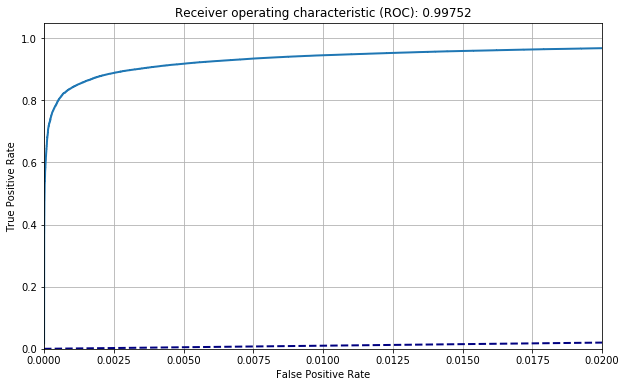

In [83]:
auc = metrics.roc_auc_score(ytest, all_preds[-1])
fpr, tpr, _ = metrics.roc_curve(ytest, all_preds[-1])

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.5f)" % auc)
plt.plot([0, 1], [0, 1], lw=2, color='navy', linestyle='--')
plt.xlim([0.0, 0.02])
plt.ylim([0.0, 1.05])
# plt.yscale("log")
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC): %.5f' % auc)
plt.show()

### Score and margin distribution

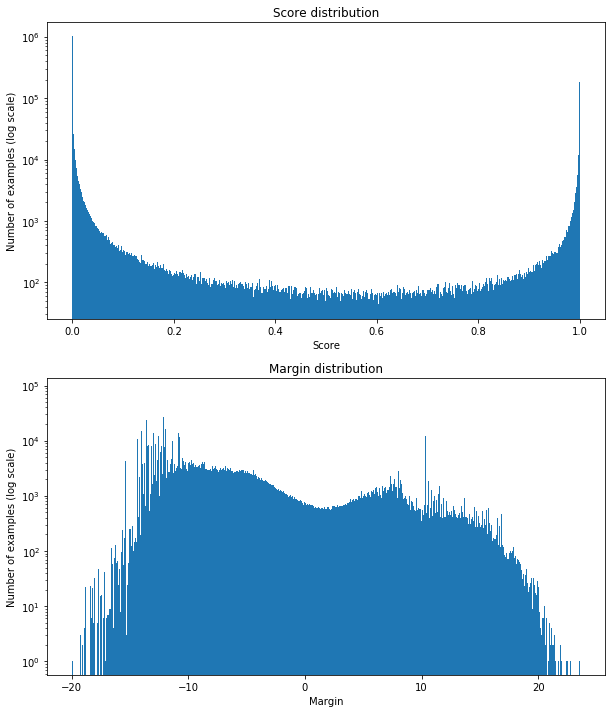

In [99]:
def plt_dist(preds, path, label=None, log_scale=False):
    plt.subplot(211)
    plt.hist(preds, bins=1000, label=label)
    if log_scale:
        plt.yscale('log')
    if label:
        plt.legend()
    plt.title("Score distribution")
    plt.ylabel("Number of examples (log scale)")
    plt.xlabel("Score")
    plt.subplot(212)
    plt.hist(path, bins=1000, label=label)
    if log_scale:
        plt.yscale('log')
    if label:
        plt.legend()
    plt.title("Margin distribution")
    plt.ylabel("Number of examples (log scale)")
    plt.xlabel("Margin")


plt.figure(figsize=(10, 12))
plt_dist(all_preds[-1], path[:, -1], log_scale=True)

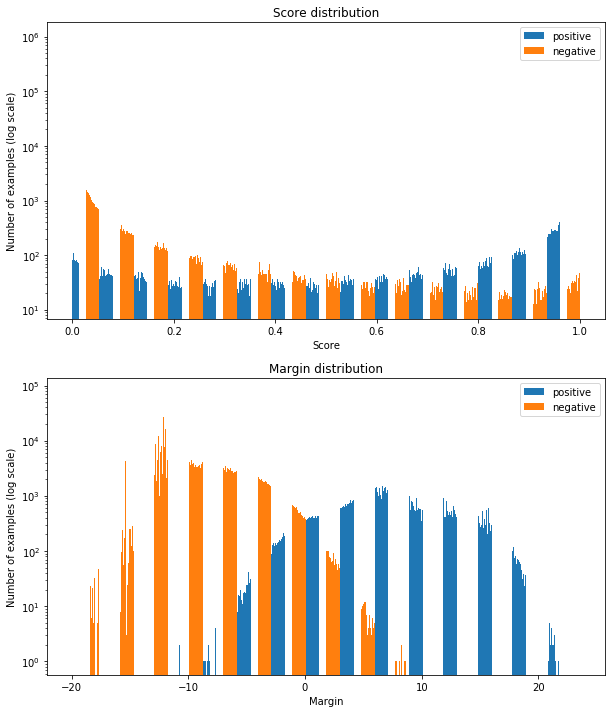

In [100]:
plt.figure(figsize=(10, 12))
plt_dist(
    (all_preds[-1][ytest_array], all_preds[-1][no_ytest_array]),
    (path[ytest_array, -1], path[no_ytest_array, -1]),
    label=["positive", "negative"],
    log_scale=False
)

### Trajectory of scores

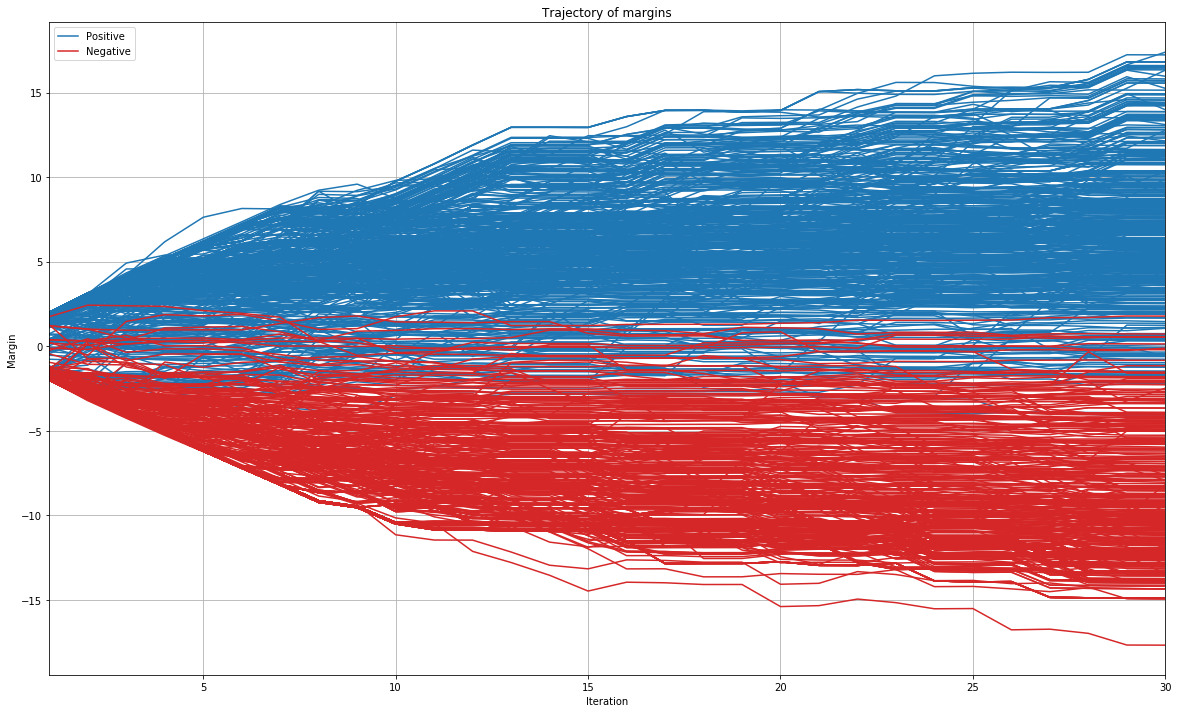

In [52]:
T = 500

num_trees = list(range(1, path.shape[1] + 1))
positive_c = "#1f77b4"
negative_c = "#d62728"
plt.figure(figsize=(20, 12))
plt.plot(num_trees, path[ytest_array][:T].T, c=positive_c)
plt.plot(num_trees, path[ytest_array][T].T, c=positive_c, label="Positive")
plt.plot(num_trees, path[no_ytest_array][:T].T, c=negative_c)
plt.plot(num_trees, path[no_ytest_array][T].T, c=negative_c, label="Negative")
plt.title("Trajectory of margins")
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.xlim(1, path.shape[1])
plt.grid()
plt.legend();